In [1]:
import numpy as np
import pandas as pd

from itertools import product
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from math import sqrt

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from xgboost import XGBRegressor
from xgboost import plot_importance

from hyperopt import fmin, tpe, hp, STATUS_OK, STATUS_FAIL, Trials, space_eval

import time
import sys
import gc
import pickle

In [2]:
items = pd.read_csv('../data/items.csv')
shops = pd.read_csv('../data/shops.csv')
cats = pd.read_csv('../data/item_categories.csv')
train = pd.read_csv('../data/sales_train.csv')
test  = pd.read_csv('../data/test.csv').set_index('ID')

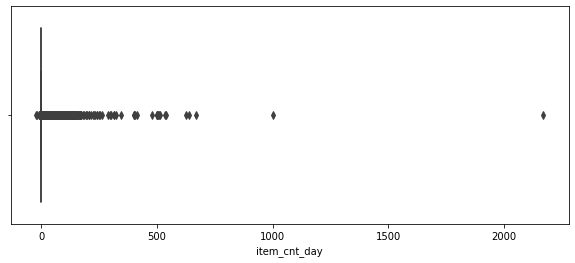

In [3]:
# Plot item count by day
plt.figure(figsize=(10, 4))
sns.boxplot(x=train['item_cnt_day'])

In [4]:
# Remove the outlier
train = train[train['item_cnt_day'] < 1001]

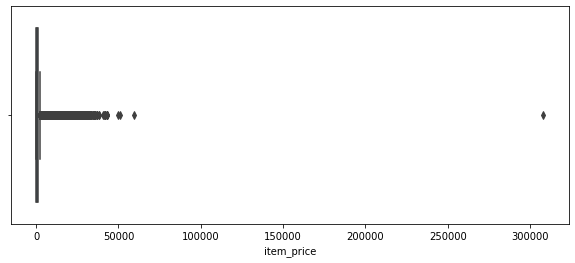

In [5]:
# Plot item price
plt.figure(figsize=(10, 4))
sns.boxplot(x=train['item_price'])

In [6]:
# Remove the outlier
train = train[train['item_price'] < 100000]

In [7]:
# Any negative prices?
train[train['item_price'] < 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.0,1.0


In [8]:
# Fill it with the median value from other item_prices associated with date_block_num, shop_id, item_id
val = train[(train['shop_id'] == 32) & (train['item_id'] == 2973) &
            (train['date_block_num'] == 4) & (train['item_price'] > 0)]['item_price'].median()

In [9]:
val

1874.0

In [10]:
train.loc[train['item_price'] < 0, 'item_price'] = val

In [11]:
np.sort(train['shop_id'].unique())

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59])

In [12]:
shops

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4
5,"Вологда ТРЦ ""Мармелад""",5
6,"Воронеж (Плехановская, 13)",6
7,"Воронеж ТРЦ ""Максимир""",7
8,"Воронеж ТРЦ Сити-Парк ""Град""",8
9,Выездная Торговля,9


In [13]:
# Some of the shop names are dups with slightly different spellings. fix these

# Якутск Орджоникидзе, 56
train.loc[train['shop_id'] == 0, 'shop_id'] = 57
test.loc[test['shop_id'] == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train['shop_id'] == 1, 'shop_id'] = 58
test.loc[test['shop_id'] == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
train.loc[train['shop_id'] == 10, 'shop_id'] = 11
test.loc[test['shop_id'] == 10, 'shop_id'] = 11

shops = shops[~shops.isin([0, 1, 10])].dropna().astype({'shop_name': 'object', 'shop_id': 'int64'})

# Fix typos. Thanks https://www.kaggle.com/dlarionov/feature-engineering-xgboost
shops.loc[shops['shop_name'] == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'

In [14]:
train['revenue'] = train['item_price'] *  train['item_cnt_day']

In [15]:
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)

## Feature Engineering

In [16]:
# Each shop_name starts with the city name. Keep this as a feature
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])

In [17]:
# Convert cities to values
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
# Keep numeric featuers
shops = shops[['shop_id', 'city_code']]

In [18]:
cats

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4
...,...,...
79,Служебные,79
80,Служебные - Билеты,80
81,Чистые носители (шпиль),81
82,Чистые носители (штучные),82


In [19]:
# Split out the item_category_name
cats['split'] = cats['item_category_name'].str.split('-')

In [20]:
# Keep the first value (type) and encode it
cats['type'] = cats['split'].map(lambda x: x[0].strip())
cats['type_code'] = LabelEncoder().fit_transform(cats['type'])

In [21]:
# Keep subtype. Make this type if it doesn't exist
cats['subtype'] = cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats['subtype_code'] = LabelEncoder().fit_transform(cats['subtype'])

In [22]:
# Keep numeric featuers
cats = cats[['item_category_id','type_code', 'subtype_code']]

In [23]:
items

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40
...,...,...,...
22165,"Ядерный титбит 2 [PC, Цифровая версия]",22165,31
22166,Язык запросов 1С:Предприятия [Цифровая версия],22166,54
22167,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,22167,49
22168,Яйцо для Little Inu,22168,62


In [24]:
# Keep numeric featuers
items.drop(['item_name'], axis=1, inplace=True)

In [25]:
print(len(list(set(test['item_id']) - set(test['item_id']).intersection(set(train['item_id'])))))
print(len(list(set(test['item_id']))))
print(len(list(set(test['shop_id']))))
print(len(list(set(train['date_block_num']))))
print(len(test))

363
5100
42
34
214200


In [26]:
# 363 items new in test set
# 5100 items in test
# 42 shops in test
# 34 months in train
# 5100 items * 42 shops = 214200 objects.

In [27]:
matrix = []
cols = ['date_block_num', 'shop_id', 'item_id']
for i in range(len(list(set(train['date_block_num'])))):
    tmp = train[train['date_block_num'] == i]
    # Create a list of month, shop id and item id combinations
    matrix.append(np.array(list(product([i], tmp['shop_id'].unique(),
                                        tmp['item_id'].unique())), dtype='int16'))

matrix = pd.DataFrame(np.vstack(matrix),
                      columns=cols
                     ).astype({'date_block_num': 'int8', 'shop_id': 'int8', 'item_id': 'int16'})
matrix.sort_values(cols, inplace=True)

In [28]:
matrix

,date_block_num,shop_id,item_id
114910,0,2,19
117150,0,2,27
120623,0,2,28
118316,0,2,29
114602,0,2,32
...,...,...,...
10768788,33,59,22162
10768978,33,59,22163
10769644,33,59,22164
10771170,33,59,22166


In [29]:
# Aggregate train set by shop/item pairs
group = train.groupby(['date_block_num', 'shop_id', 'item_id']).agg({'item_cnt_day': ['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=cols, how='left')
matrix['item_cnt_month'] = (matrix['item_cnt_month'].fillna(0).clip(0,20) # NB clip target here
                            .astype(np.float16))

In [30]:
matrix

,date_block_num,shop_id,item_id,item_cnt_month
0,0,2,19,0.0
1,0,2,27,1.0
2,0,2,28,0.0
3,0,2,29,0.0
4,0,2,32,0.0
...,...,...,...,...
10913799,33,59,22162,0.0
10913800,33,59,22163,0.0
10913801,33,59,22164,0.0
10913802,33,59,22166,0.0


In [31]:
# Append test to train
matrix = pd.concat([matrix, test], ignore_index=True, sort=False, keys=cols)
matrix.fillna(0, inplace=True) # 34 month

In [32]:
matrix

,date_block_num,shop_id,item_id,item_cnt_month
0,0,2,19,0.0
1,0,2,27,1.0
2,0,2,28,0.0
3,0,2,29,0.0
4,0,2,32,0.0
...,...,...,...,...
11127999,34,45,18454,0.0
11128000,34,45,16188,0.0
11128001,34,45,15757,0.0
11128002,34,45,19648,0.0


In [33]:
# Bring in city code
matrix = pd.merge(matrix, shops, on=['shop_id'], how='left')
# Bring in item category id
matrix = pd.merge(matrix, items, on=['item_id'], how='left')
# Bring in type_code and subtype_code
matrix = pd.merge(matrix, cats, on=['item_category_id'], how='left'
                 ).astype({'city_code': 'int8', 'item_category_id': 'int8',
                           'type_code': 'int16', 'subtype_code': 'int8'})

In [34]:
matrix

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code
0,0,2,19,0.0,0,40,11,4
1,0,2,27,1.0,0,19,5,10
2,0,2,28,0.0,0,30,8,55
3,0,2,29,0.0,0,23,5,16
4,0,2,32,0.0,0,40,11,4
...,...,...,...,...,...,...,...,...
11127999,34,45,18454,0.0,20,55,13,2
11128000,34,45,16188,0.0,20,64,14,42
11128001,34,45,15757,0.0,20,55,13,2
11128002,34,45,19648,0.0,20,40,11,4


In [35]:
# Show how a lag feature works e.g. a lag of 1
tmp = matrix[['date_block_num', 'shop_id', 'item_id', 'item_cnt_month']]
shifted = tmp.copy()
shifted.columns = ['date_block_num', 'shop_id', 'item_id', 'item_cnt_month' + '_lag_1']
shifted['date_block_num'] += 1
pd.merge(matrix, shifted, on=['date_block_num', 'shop_id', 'item_id'], how='left')

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1
0,0,2,19,0.0,0,40,11,4,NaN
1,0,2,27,1.0,0,19,5,10,NaN
2,0,2,28,0.0,0,30,8,55,NaN
3,0,2,29,0.0,0,23,5,16,NaN
4,0,2,32,0.0,0,40,11,4,NaN
...,...,...,...,...,...,...,...,...,...
11127999,34,45,18454,0.0,20,55,13,2,1.0
11128000,34,45,16188,0.0,20,64,14,42,0.0
11128001,34,45,15757,0.0,20,55,13,2,0.0
11128002,34,45,19648,0.0,20,40,11,4,0.0


In [36]:
# Do lags of 1, 2, 3, 6, 12
def lag_feature(df, lags, col):
    tmp = df[['date_block_num', 'shop_id', 'item_id', col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num', 'shop_id', 'item_id', col + '_lag_' + str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num', 'shop_id', 'item_id'], how='left')
    return df
matrix = lag_feature(matrix, [1, 2, 3, 6, 12], 'item_cnt_month')

In [37]:
matrix

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12
0,0,2,19,0.0,0,40,11,4,NaN,NaN,NaN,NaN,NaN
1,0,2,27,1.0,0,19,5,10,NaN,NaN,NaN,NaN,NaN
2,0,2,28,0.0,0,30,8,55,NaN,NaN,NaN,NaN,NaN
3,0,2,29,0.0,0,23,5,16,NaN,NaN,NaN,NaN,NaN
4,0,2,32,0.0,0,40,11,4,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11127999,34,45,18454,0.0,20,55,13,2,1.0,0.0,0.0,0.0,NaN
11128000,34,45,16188,0.0,20,64,14,42,0.0,0.0,NaN,NaN,NaN
11128001,34,45,15757,0.0,20,55,13,2,0.0,0.0,0.0,0.0,0.0
11128002,34,45,19648,0.0,20,40,11,4,0.0,0.0,0.0,0.0,NaN


In [38]:
# Mean encode date_block_num and add lag of 1
group = matrix.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num'], how='left')
matrix['date_avg_item_cnt'] = matrix['date_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_avg_item_cnt')
matrix.drop(['date_avg_item_cnt'], axis=1, inplace=True)

In [39]:
# Mean encode date_block_num and item_id and add lags
group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_item_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_cnt'] = matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1, 2, 3, 6, 12], 'date_item_avg_item_cnt')
matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)

In [40]:
# Mean encode date_block_num and shop_id and add lags
group = matrix.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_avg_item_cnt'] = matrix['date_shop_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1, 2, 3, 6, 12], 'date_shop_avg_item_cnt')
matrix.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)

In [41]:
# Mean encode date_block_num and item_category_id and add lag of 1
group = matrix.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_cat_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_category_id'], how='left')
matrix['date_cat_avg_item_cnt'] = matrix['date_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_cat_avg_item_cnt')
matrix.drop(['date_cat_avg_item_cnt'], axis=1, inplace=True)

In [42]:
# Mean encode date_block_num, shop_id, item_category_id and add lag of 1
group = matrix.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_cat_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
matrix['date_shop_cat_avg_item_cnt'] = matrix['date_shop_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_cat_avg_item_cnt')
matrix.drop(['date_shop_cat_avg_item_cnt'], axis=1, inplace=True)

In [43]:
# Mean encode date_block_num, shop_id, type_code and add lag of 1
group = matrix.groupby(['date_block_num', 'shop_id', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_type_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'type_code'], how='left')
matrix['date_shop_type_avg_item_cnt'] = matrix['date_shop_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_type_avg_item_cnt')
matrix.drop(['date_shop_type_avg_item_cnt'], axis=1, inplace=True)

In [44]:
# Mean encode date_block_num, shop_id, subtype_code and add lag of 1
group = matrix.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_subtype_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'subtype_code'], how='left')
matrix['date_shop_subtype_avg_item_cnt'] = matrix['date_shop_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_subtype_avg_item_cnt')
matrix.drop(['date_shop_subtype_avg_item_cnt'], axis=1, inplace=True)

In [45]:
# Mean encode date_block_num and city_code and add lag of 1
group = matrix.groupby(['date_block_num', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_city_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'city_code'], how='left')
matrix['date_city_avg_item_cnt'] = matrix['date_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_city_avg_item_cnt')
matrix.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)

In [46]:
# Mean encode date_block_num, item_id and city_code and add lag of 1
group = matrix.groupby(['date_block_num', 'item_id', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id', 'city_code'], how='left')
matrix['date_item_city_avg_item_cnt'] = matrix['date_item_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_item_city_avg_item_cnt')
matrix.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)

In [47]:
# Mean encode date_block_num and type_code and add lag of 1
group = matrix.groupby(['date_block_num', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_type_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'type_code'], how='left')
matrix['date_type_avg_item_cnt'] = matrix['date_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_type_avg_item_cnt')
matrix.drop(['date_type_avg_item_cnt'], axis=1, inplace=True)

In [48]:
# Mean encode date_block_num and subtype_code and add lag of 1
group = matrix.groupby(['date_block_num', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_subtype_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'subtype_code'], how='left')
matrix['date_subtype_avg_item_cnt'] = matrix['date_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_subtype_avg_item_cnt')
matrix.drop(['date_subtype_avg_item_cnt'], axis=1, inplace=True)

In [49]:
matrix.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'city_code',
       'item_category_id', 'type_code', 'subtype_code', 'item_cnt_month_lag_1',
       'item_cnt_month_lag_2', 'item_cnt_month_lag_3', 'item_cnt_month_lag_6',
       'item_cnt_month_lag_12', 'date_avg_item_cnt_lag_1',
       'date_item_avg_item_cnt_lag_1', 'date_item_avg_item_cnt_lag_2',
       'date_item_avg_item_cnt_lag_3', 'date_item_avg_item_cnt_lag_6',
       'date_item_avg_item_cnt_lag_12', 'date_shop_avg_item_cnt_lag_1',
       'date_shop_avg_item_cnt_lag_2', 'date_shop_avg_item_cnt_lag_3',
       'date_shop_avg_item_cnt_lag_6', 'date_shop_avg_item_cnt_lag_12',
       'date_cat_avg_item_cnt_lag_1', 'date_shop_cat_avg_item_cnt_lag_1',
       'date_shop_type_avg_item_cnt_lag_1',
       'date_shop_subtype_avg_item_cnt_lag_1', 'date_city_avg_item_cnt_lag_1',
       'date_item_city_avg_item_cnt_lag_1', 'date_type_avg_item_cnt_lag_1',
       'date_subtype_avg_item_cnt_lag_1'],
      dtype='object')

In [50]:
train.columns

Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day', 'revenue'],
      dtype='object')

In [51]:
# Encode item id with mean item price
group = train.groupby(['item_id']).agg({'item_price': ['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['item_id'], how='left')
matrix['item_avg_item_price'] = matrix['item_avg_item_price'].astype(np.float16)

In [52]:
# Encode date_block_num, item_id with mean price
group = train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_price'] = matrix['date_item_avg_item_price'].astype(np.float16)

lags = [1,2,3,4,5,6]
matrix = lag_feature(matrix, lags, 'date_item_avg_item_price')

In [53]:
# Work out trends as subtract present from lag
for i in lags:
    matrix['delta_price_lag_'+str(i)] = (matrix['date_item_avg_item_price_lag_'+str(i)] -
                                         matrix['item_avg_item_price'])
    / matrix['item_avg_item_price']

In [54]:
# Fill na's with 0
def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0

matrix['delta_price_lag'] = matrix.apply(select_trend, axis=1)
matrix['delta_price_lag'] = matrix['delta_price_lag'].astype(np.float16)
matrix['delta_price_lag'].fillna(0, inplace=True)

In [55]:
# Remove some features
fetures_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    fetures_to_drop += ['date_item_avg_item_price_lag_' + str(i)]
    fetures_to_drop += ['delta_price_lag_' + str(i)]

matrix.drop(fetures_to_drop, axis=1, inplace=True)

In [56]:
# Last month shop revenue trend
# Encode date_block_num, shop_id with revenue sum
group = train.groupby(['date_block_num', 'shop_id']).agg({'revenue': ['sum']})
group.columns = ['date_shop_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)

In [57]:
# Encode shop_id with revenue mean
group = group.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
group.columns = ['shop_avg_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['shop_id'], how='left')
matrix['shop_avg_revenue'] = matrix['shop_avg_revenue'].astype(np.float32)

In [58]:
# Difference of each shop compared to average
matrix['delta_revenue'] = (matrix['date_shop_revenue']
                           - matrix['shop_avg_revenue'])
/ matrix['shop_avg_revenue']
matrix['delta_revenue'] = matrix['delta_revenue'].astype(np.float16)

matrix = lag_feature(matrix, [1], 'delta_revenue')

In [59]:
matrix.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'],
            axis=1, inplace=True)

In [60]:
# Convert date_block_mon to month num
matrix['month'] = matrix['date_block_num'] % 12

In [61]:
# Add number of days of a month
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix['days'] = matrix['month'].map(days).astype(np.int8)

In [62]:
# Months since the last sale for each shop/item pair and for item only

# Create HashTable with key equals to {shop_id,item_id} and value equals to date_block_num.
# Iterate data from the top. Foreach row if {row.shop_id,row.item_id} is not present in the table,
# then add it to the table and set its value to row.date_block_num.
# if HashTable contains key, then calculate the difference beteween cached value and row.date_block_num.

cache = {}
matrix['item_shop_last_sale'] = -1
matrix['item_shop_last_sale'] = matrix['item_shop_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = str(row.item_id) + ' ' + str(row.shop_id)
    if key not in cache:
        if row.item_cnt_month != 0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        matrix.at[idx, 'item_shop_last_sale'] = row.date_block_num - last_date_block_num
        cache[key] = row.date_block_num
        
cache = {}
matrix['item_last_sale'] = -1
matrix['item_last_sale'] = matrix['item_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = row.item_id
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        if row.date_block_num > last_date_block_num:
            matrix.at[idx, 'item_last_sale'] = row.date_block_num - last_date_block_num
            cache[key] = row.date_block_num

In [63]:
# Months since the first sale for each shop/item pair and for item only.
matrix['item_shop_first_sale'] = matrix['date_block_num'] - matrix.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
matrix['item_first_sale'] = matrix['date_block_num'] - matrix.groupby('item_id')['date_block_num'].transform('min')

In [64]:
# Because of the using 12 as lag value drop first 12 months.
# Also drop all the columns with this month calculated values
# (other words which can not be calcucated for the test set).
matrix = matrix[matrix.date_block_num > 11]

In [65]:
# Fill NaN with 0
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)         
    return df

matrix = fill_na(matrix)

In [66]:
matrix.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'city_code',
       'item_category_id', 'type_code', 'subtype_code', 'item_cnt_month_lag_1',
       'item_cnt_month_lag_2', 'item_cnt_month_lag_3', 'item_cnt_month_lag_6',
       'item_cnt_month_lag_12', 'date_avg_item_cnt_lag_1',
       'date_item_avg_item_cnt_lag_1', 'date_item_avg_item_cnt_lag_2',
       'date_item_avg_item_cnt_lag_3', 'date_item_avg_item_cnt_lag_6',
       'date_item_avg_item_cnt_lag_12', 'date_shop_avg_item_cnt_lag_1',
       'date_shop_avg_item_cnt_lag_2', 'date_shop_avg_item_cnt_lag_3',
       'date_shop_avg_item_cnt_lag_6', 'date_shop_avg_item_cnt_lag_12',
       'date_cat_avg_item_cnt_lag_1', 'date_shop_cat_avg_item_cnt_lag_1',
       'date_shop_type_avg_item_cnt_lag_1',
       'date_shop_subtype_avg_item_cnt_lag_1', 'date_city_avg_item_cnt_lag_1',
       'date_item_city_avg_item_cnt_lag_1', 'date_type_avg_item_cnt_lag_1',
       'date_subtype_avg_item_cnt_lag_1', 'delta_price_lag',
       'delta

In [67]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6639294 entries, 4488710 to 11128003
Data columns (total 40 columns):
date_block_num                          int8
shop_id                                 int8
item_id                                 int16
item_cnt_month                          float16
city_code                               int8
item_category_id                        int8
type_code                               int16
subtype_code                            int8
item_cnt_month_lag_1                    float16
item_cnt_month_lag_2                    float16
item_cnt_month_lag_3                    float16
item_cnt_month_lag_6                    float16
item_cnt_month_lag_12                   float16
date_avg_item_cnt_lag_1                 float16
date_item_avg_item_cnt_lag_1            float16
date_item_avg_item_cnt_lag_2            float16
date_item_avg_item_cnt_lag_3            float16
date_item_avg_item_cnt_lag_6            float16
date_item_avg_item_cnt_lag_12      

In [68]:
matrix.to_pickle('../data/data.pkl')

In [69]:
test.to_pickle('../data/test.pkl')